In [ ]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import (
    DataLoader,
    Dataset
)
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.rnn import PredRNN

In [5]:
warnings.filterwarnings("ignore")

#### **Data Preprocessing:**

In [ ]:
def extract_frames(
    video_path: str,
    output_folder: str,
    frame_rate: int=1,
    skip_frames: bool=False
    ) -> list:
        """
            Extracts frames from a video file and saves them as images.

            This function reads a video from `video_path`, extracts frames at the specified `frame_rate`, and saves them to `output_folder`.
            It can optionally skip frames based on the `skip_frames` flag.

            Arguments:
                video_path (str): Path to the input video file.
                output_folder (str): Directory where the extracted frames will be saved.
                frame_rate (int, optional): Number of frames to extract per second. Defaults to 1.
                skip_frames (bool, optional): If True, skips frames based on the frame rate. Defaults to False.

            Returns:
                list: A list of filenames for the extracted frames.
        """  
        if not os.path.exists(output_folder):
            os.makedirs(name=output_folder)
        cap=cv2.VideoCapture(filename=video_path)
        fps=int(cap.get(propId=cv2.CAP_PROP_FPS))
        frame_names=[]
        frame_count=0
        while cap.isOpened():
            ret, frame=cap.read()
            if not ret:
                break
            if skip_frames:
                if frame_count%(fps//frame_rate)==0:
                    video_name=re.search(
                        pattern="v_[^\\/]+(?=\\.)",
                        string=video_path
                    ).group(0)
                    frame_name=f"{video_name}_frame_{frame_count}.jpg"
                    frame_path=os.path.join(output_folder, frame_name)
                    cv2.imwrite(
                        filename=frame_path,
                        img=frame
                    )
                    frame_names.append(frame_name)
                    frame_count+=1
            else:
                video_name=re.search(
                    pattern="v_[^\\/]+(?=\\.)",
                    string=video_path
                ).group(0)
                frame_name=f"{video_name}_frame_{frame_count}.jpg"
                frame_path=os.path.join(output_folder, frame_name)
                cv2.imwrite(
                    filename=frame_path,
                    img=frame
                )
                frame_names.append(frame_name)
                frame_count+=1
        cap.release()
        return frame_names

In [ ]:
def preprocess_frame(
    image_path: str,
    target_size: tuple=(64, 64)
) -> np.ndarray:
    """
    Preprocesses an image by resizing and normalizing it.

    This function opens an image from `image_path`, resizes it to `target_size`, and normalizes the pixel values to the range [0, 1].

    Arguments:
        image_path (str): Path to the input image file.
        target_size (tuple, optional): Desired size for the output image as (width, height). Defaults to (64, 64).

    Returns:
        np.ndarray: The preprocessed image as a NumPy array with normalized pixel values.
    """
    image=Image.open(fp=image_path).resize(size=target_size)
    image_array=np.array(object=image)/255.0
    return image_array

In [8]:
input_folders=[r"app/data/videos/BreastStroke", r"app/data/videos/Kayaking", r"app/data/videos/Rafting", r"app/data/videos/Rowing", r"app/data/videos/Surfing"]
frame_folder=r"app/data/frames"
video_files=[]
for input_folder in input_folders:
    video_files.extend(
        os.listdir(input_folder)
    )
video_paths=[]
for input_folder in input_folders:
    video_files=os.listdir(input_folder)
    video_paths.extend([
        os.path.join(input_folder, video_file)
        for video_file in video_files
    ])
dataframe=pd.DataFrame(columns=["video_file", "frame_file"])
for video_path in tqdm(
    iterable=video_paths,
    desc="Extracting Frames",
    unit="video"
):
    video_file=os.path.basename(p=video_path)
    frame_paths=extract_frames(
        video_path=video_path,
        output_folder=frame_folder
    )
    for frame_path in frame_paths:
        dataframe=pd.concat(
            objs=[dataframe, pd.DataFrame(
                    data=[[video_file, frame_path]],
                    columns=["video_file", "frame_file"]
                )
            ],
            ignore_index=True
        )
dataframe["label"]=dataframe["video_file"].apply(lambda x: x.split("_")[1])
dataframe

Extracting Frames: 100%|██████████| 459/459 [02:49<00:00,  2.71video/s]


,video_file,frame_file,label
0,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_0.jpg,BreastStroke
1,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_1.jpg,BreastStroke
2,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_2.jpg,BreastStroke
3,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_3.jpg,BreastStroke
4,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_4.jpg,BreastStroke
...,...,...,...
102098,v_Surfing_g08_c01.avi,v_Surfing_g08_c01_frame_187.jpg,Surfing
102099,v_Surfing_g08_c01.avi,v_Surfing_g08_c01_frame_188.jpg,Surfing
102100,v_Surfing_g08_c01.avi,v_Surfing_g08_c01_frame_189.jpg,Surfing
102101,v_Surfing_g08_c01.avi,v_Surfing_g08_c01_frame_190.jpg,Surfing


In [9]:
sample_dataframe=dataframe.groupby(
    by="label",
    group_keys=False
).apply(lambda x: x[x["video_file"].isin(x["video_file"].unique()[:50])]).reset_index(drop=True)
sample_dataframe

,video_file,frame_file,label
0,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_0.jpg,BreastStroke
1,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_1.jpg,BreastStroke
2,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_2.jpg,BreastStroke
3,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_3.jpg,BreastStroke
4,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_4.jpg,BreastStroke
...,...,...,...
53733,v_Surfing_g11_c03.avi,v_Surfing_g11_c03_frame_145.jpg,Surfing
53734,v_Surfing_g11_c03.avi,v_Surfing_g11_c03_frame_146.jpg,Surfing
53735,v_Surfing_g11_c03.avi,v_Surfing_g11_c03_frame_147.jpg,Surfing
53736,v_Surfing_g11_c03.avi,v_Surfing_g11_c03_frame_148.jpg,Surfing


In [ ]:
def filter_dataframe(
    video_files: pd.DataFrame,
    dataframe: pd.DataFrame
) -> pd.DataFrame:
    """
    Filters a dataframe to include only rows with specified video files.

    This function returns a subset of `dataframe` where the "video_file" column values are present in the `video_files` dataframe.

    Arguments:
        video_files (pd.DataFrame): DataFrame containing the video files to filter by, with a "video_file" column.
        dataframe (pd.DataFrame): The original dataframe to be filtered, containing a "video_file" column.

    Returns:
        pd.DataFrame: A filtered dataframe containing only the rows with video files present in `video_files`.
    """
    return dataframe[dataframe["video_file"].isin(values=video_files["video_file"])]

In [11]:
video_file_labels=sample_dataframe[["video_file", "label"]].drop_duplicates()
train_files, temporary_files=train_test_split(
    video_file_labels,
    test_size=0.2,
    stratify=video_file_labels["label"],
    random_state=42
)
validation_files, test_files=train_test_split(
    temporary_files,
    test_size=0.5,
    stratify=temporary_files["label"],
    random_state=42
)
train_set=filter_dataframe(
    video_files=train_files,
    dataframe=sample_dataframe
)
validation_set=filter_dataframe(
    video_files=validation_files,
    dataframe=sample_dataframe
)
test_set=filter_dataframe(
    video_files=test_files,
    dataframe=sample_dataframe
)
train_set=train_set.reset_index(drop=True)
validation_set=validation_set.reset_index(drop=True)
test_set=test_set.reset_index(drop=True)
tqdm.pandas()
train_set["prepared_frame"]=train_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
validation_set["prepared_frame"]=validation_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
test_set["prepared_frame"]=test_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
print("Training Set:", train_set["label"].value_counts())
print("Validation Set:", validation_set["label"].value_counts())
print("Test Set:", test_set["label"].value_counts())

100%|██████████| 4900/4900 [00:07<00:00, 654.07it/s]

Training Set: label
Rowing          12418
Surfing          8375
Kayaking         7637
BreastStroke     7566
Rafting          7422
Name: count, dtype: int64
Validation Set: label
Rowing          1572
Surfing         1272
Rafting         1086
Kayaking         918
BreastStroke     572
Name: count, dtype: int64
Test Set: label
Rowing          1232
Surfing         1138
Rafting         1115
Kayaking         854
BreastStroke     561
Name: count, dtype: int64


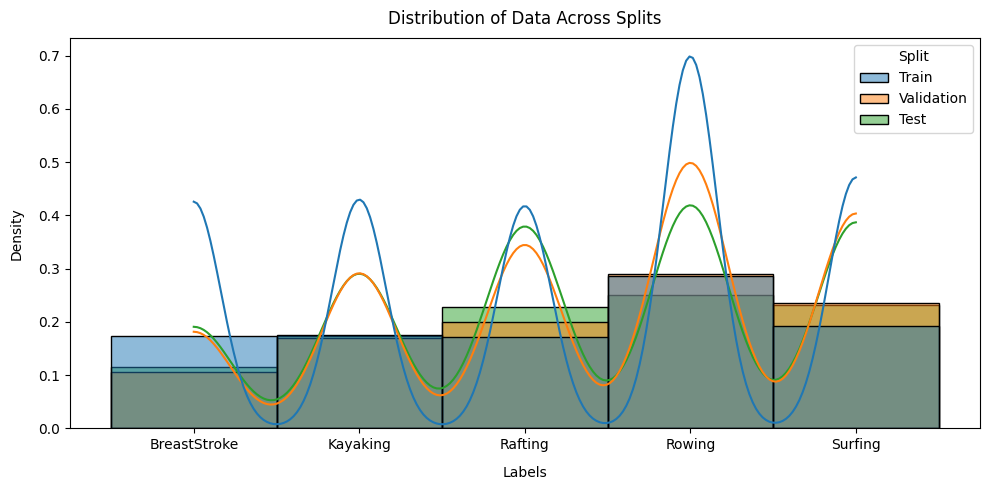

In [12]:
train_set["Split"]="Train"
validation_set["Split"]="Validation"
test_set["Split"]="Test"
combined_set=pd.concat(objs=[train_set, validation_set, test_set])
plt.figure(figsize=(10, 5))
sns.histplot(
    data=combined_set,
    x="label",
    hue="Split",
    stat="density",
    common_norm=False,
    kde=True,
    bins=20
)
plt.xlabel(
    xlabel="Labels",
    labelpad=10,
    fontdict={"fontsize": 10}
)
plt.ylabel(
    ylabel="Density",
    labelpad=10,
    fontdict={"fontsize": 10}
)
plt.title(
    label="Distribution of Data Across Splits",
    pad=10,
    fontdict={"fontsize": 12}
)
plt.tight_layout()
plt.show()
train_set=train_set.drop(columns="Split")
validation_set=validation_set.drop(columns="Split")
test_set=test_set.drop(columns="Split")

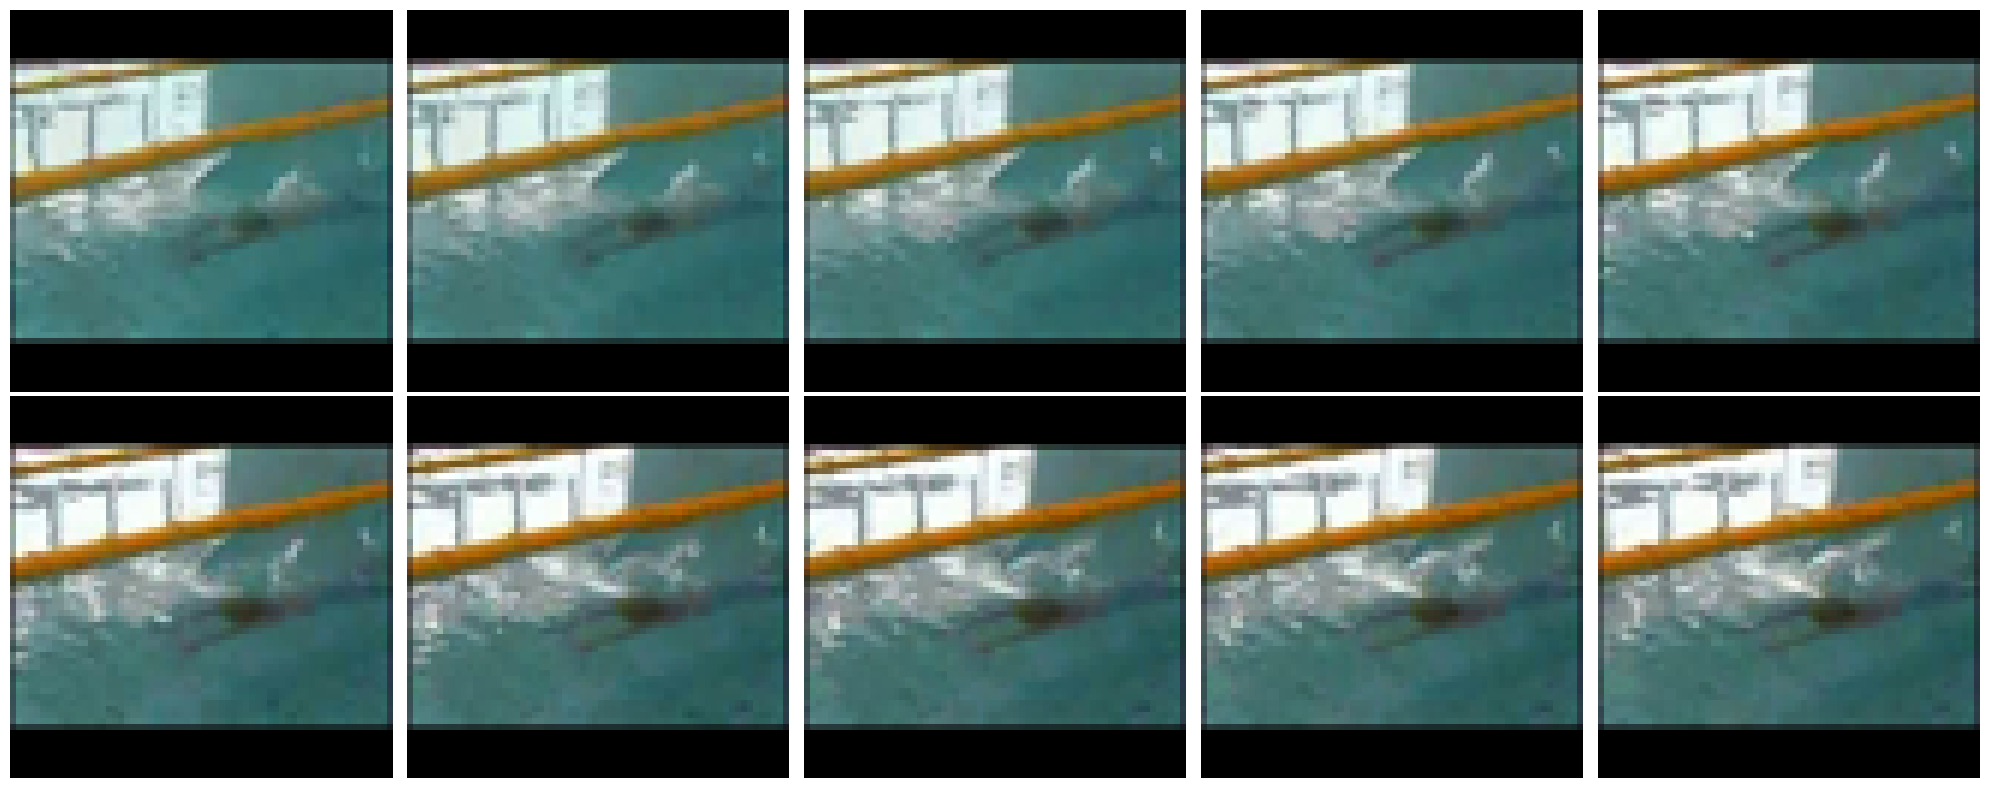

In [13]:
example_frames=train_set[train_set["video_file"]==train_set["video_file"][0]]["prepared_frame"].values
_, axes=plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(20, 8)
)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X=example_frames[i])
    ax.axis("off")
plt.tight_layout()
plt.show()

#### **Video Generation:**

In [ ]:
def create_video(
    frames: list,
    video_path: str,
    fps: int=10
):
    """
    Creates a video file from a list of frames.

    This function takes a list of frames, converts them to the appropriate format, and writes them to a video file at the specified `video_path`.

    Arguments:
        frames (list): A list of frames (as NumPy arrays) to be compiled into a video.
        video_path (str): The path where the output video will be saved.
        fps (int, optional): Frames per second for the output video. Defaults to 10.
    """
    frame_shape = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(
        filename=video_path,
        fourcc=fourcc,
        fps=fps,
        frameSize=(frame_shape[1], frame_shape[0]),
        isColor=True
    )
    for frame in tqdm(
        iterable=frames,
        desc="Creating Video",
        unit="frame"
    ):
        frame = (frame * 255).astype(np.uint8)
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)) 
    out.release()


In [15]:
video_path=r"app/out/tests/example_video.mp4"
create_video(
    frames=example_frames,
    video_path=video_path
)

Creating Video: 100%|██████████| 127/127 [00:00<00:00, 37832.15frame/s]


#### **Batch Processing:**

In [ ]:
class VideoDataset(Dataset):
    """
    A PyTorch Dataset class for loading sequences of video frames for training and evaluation.

    This dataset organizes video frames into sequences of a specified length, allowing models to learn temporal dependencies.
    It handles the grouping of frames by video file and prepares samples consisting of input frame sequences and target frames.

    Arguments:
        dataframe (pd.DataFrame): A dataframe containing video file information and corresponding prepared frame data.
            The dataframe must include at least two columns:
                - "video_file": The name or path of the video file.
                - "prepared_frame": The preprocessed frame data, typically as NumPy arrays or tensors.
        sequence_length (int, optional): The total length of each sequence, including input and target frames. Defaults to 11.

    Attributes:
        dataframe (pd.DataFrame): The original dataframe containing video and frame information.
        sequence_length (int): The total number of frames per sequence.
        video_groups (pd.Series): A series where each entry is a list of prepared frames for a video file.
    """
    def __init__(
        self: None,
        dataframe: pd.DataFrame,
        sequence_length: int=11
    ) -> None:
        self.dataframe=dataframe
        self.sequence_length=sequence_length
        self.video_groups=dataframe.groupby(by="video_file")["prepared_frame"].apply(list)

    def __len__(self: None) -> int:
        return sum(len(frames)-self.sequence_length+1 for frames in self.video_groups if len(frames)>=self.sequence_length)

    def __getitem__(
        self: None,
        index: int
    ) -> tuple:
        cumulative_index=0
        for frames in self.video_groups:
            if len(frames)>=self.sequence_length:
                num_sequences=len(frames)-self.sequence_length+1
                if index<cumulative_index+num_sequences:
                    sequence_index=index-cumulative_index
                    sequence=frames[sequence_index:sequence_index+self.sequence_length]
                    sequence=torch.stack(tensors=[torch.tensor(
                            data=f,
                            dtype=torch.float32
                        ).permute(2, 0, 1) for f in sequence]
                    )
                    input_frames=sequence[:10]
                    target_frame=sequence[10]
                    return input_frames, target_frame
                cumulative_index+=num_sequences
        raise IndexError("Index out of bounds")

In [ ]:
def collate_function(batch: list) -> tuple:
    """
    Collates a batch of data into input and target tensors for model training.

    This function takes a list of samples, where each sample is a tuple of (input_frames, target_frames),
    and stacks them into separate tensors for inputs and targets.

    Arguments:
        batch (list): A list of tuples, each containing:
            - input_frames (torch.Tensor): The input frame sequence.
            - target_frames (torch.Tensor): The target frame sequence.

    Returns:
        tuple: A tuple containing:
            - input_frames (torch.Tensor): A tensor of stacked input frame sequences. Shape: (batch_size, input_channels, H, W)
            - target_frames (torch.Tensor): A tensor of stacked target frames. Shape: (batch_size, target_channels, H, W)
    """
    input_frames, target_frames=zip(*batch)
    input_frames=torch.stack(tensors=input_frames)
    target_frames=torch.stack(tensors=target_frames)
    return input_frames, target_frames

In [28]:
train_dataset=VideoDataset(dataframe=train_set)
validation_dataset=VideoDataset(dataframe=validation_set)
test_dataset=VideoDataset(dataframe=test_set)
train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=160,
    shuffle=True,
    collate_fn=collate_function
)
validation_loader=DataLoader(
    dataset=validation_dataset,
    batch_size=160,
    shuffle=False,
    collate_fn=collate_function
)
test_loader=DataLoader(
    dataset=test_dataset,
    batch_size=160,
    shuffle=False,
    collate_fn=collate_function
)

### **PredRNN:**

In [29]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [30]:
n_channels=3
n_kernels=64
n_layers=2
kernel_size=3
padding=1
activation="relu"
model=PredRNN(
    input_channels=n_channels,
    hidden_channels=n_kernels,
    kernel_size=kernel_size,
    padding=padding,
    n_layers=n_layers,
    activation=activation
).to(device)
model

PredRNN(
  (layers): ModuleList(
    (0): PredRNNCell(
      (input_convolution): Conv2d(3, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (hidden_convolution): Conv2d(64, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (memory_convolution): Conv2d(64, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PredRNNCell(
      (input_convolution): Conv2d(64, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (hidden_convolution): Conv2d(64, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (memory_convolution): Conv2d(64, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (output_convolution): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [31]:
criterion=nn.MSELoss()
optimiser=Adam(
    params=model.parameters(),
    lr=0.001
)
scheduler=ReduceLROnPlateau(
    optimizer=optimiser,
    mode="min",
    patience=5,
    verbose=True
)

#### **Model Training:**

In [32]:
def train(
    model: nn.Module,
    criterion: nn.Module,
    optimiser: torch.optim.Optimizer,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    epochs: int,
    device: torch.device
) -> None:
    for epoch in tqdm(
        iterable=range(epochs),
        desc="Training",
        unit="epoch"
    ):
        model.train()
        train_loss=0.0
        for input_frames, target_frame in tqdm(
            iterable=train_loader,
            desc=f"Training Epoch {epoch+1}/{epochs}",
            unit="batch"
        ):
            input_frames=input_frames.to(device)
            target_frame=target_frame.to(device)
            optimiser.zero_grad()
            output=model(input_frames)
            loss=criterion(output, target_frame)
            loss.backward()
            optimiser.step()
            train_loss+=loss.item()
        train_loss/=len(train_loader)
        model.eval()
        validation_loss=0.0
        with torch.no_grad():
            for input_frames, target_frame in tqdm(
                iterable=validation_loader,
                desc=f"Validation Epoch {epoch+1}/{epochs}",
                unit="batch"
            ):
                input_frames=input_frames.to(device)
                target_frame=target_frame.to(device)
                output=model(input_frames)
                loss=criterion(output, target_frame)
                validation_loss+=loss.item()
            validation_loss/=len(validation_loader)
        scheduler.step(validation_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {validation_loss}")
        torch.save(model.state_dict(), "PredRNN_checkpoint.pth")

In [36]:
import gc

def clear_gpu_memory():
    print("Clearing GPU memory...")
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()
    torch.cuda.synchronize()
    print("GPU memory cleared.")

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

clear_gpu_memory()

Clearing GPU memory...
GPU memory cleared.


In [37]:
torch.cuda.empty_cache()
train(
    model=model,
    criterion=criterion,
    optimiser=optimiser,
    train_loader=train_loader,
    validation_loader=validation_loader,
    epochs=10,
    device=device
)

Training Epoch 1/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  10%|█         | 1/10 [05:09<46:28, 309.84s/epoch]

Epoch 1/10, Train Loss: 0.0022844999177295097, Validation Loss: 0.0023028310954969406



Training Epoch 2/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  20%|██        | 2/10 [10:19<41:18, 309.84s/epoch]

Epoch 2/10, Train Loss: 0.002222725479687388, Validation Loss: 0.0022997582555311083



Training Epoch 3/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  30%|███       | 3/10 [15:29<36:08, 309.82s/epoch]

Epoch 3/10, Train Loss: 0.0021722060870954544, Validation Loss: 0.0023050669944054926



Training Epoch 4/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  40%|████      | 4/10 [20:39<30:59, 309.86s/epoch]

Epoch 4/10, Train Loss: 0.0021356986714239344, Validation Loss: 0.0022429827356862725



Training Epoch 5/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  50%|█████     | 5/10 [25:49<25:49, 309.95s/epoch]

Epoch 5/10, Train Loss: 0.002106563749536153, Validation Loss: 0.002162594418526472



Training Epoch 6/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  60%|██████    | 6/10 [30:59<20:39, 309.89s/epoch]

Epoch 6/10, Train Loss: 0.002074500158407571, Validation Loss: 0.002141030216025132



Training Epoch 7/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  70%|███████   | 7/10 [36:09<15:29, 309.85s/epoch]

Epoch 7/10, Train Loss: 0.0020481895198721915, Validation Loss: 0.0021377793746069074



Training Epoch 8/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  80%|████████  | 8/10 [41:19<10:19, 309.90s/epoch]

Epoch 8/10, Train Loss: 0.0020216328189007105, Validation Loss: 0.0020745116271427833



Training Epoch 9/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training:  90%|█████████ | 9/10 [46:28<05:09, 309.86s/epoch]

Epoch 9/10, Train Loss: 0.002014467864419589, Validation Loss: 0.002059423067266559



Training Epoch 10/10: 100%|██████████| 259/259 [04:54<00:00,  1.14s/batch]

Training: 100%|██████████| 10/10 [51:38<00:00, 309.87s/epoch]

Epoch 10/10, Train Loss: 0.001979862360021236, Validation Loss: 0.0021195773557392936


In [ ]:
model_path=r"Pred_RNN.pth"
torch.save(
    obj=model.state_dict(),
    f=model_path
)

#### **Model Evaluation:**

In [39]:
def evaluate(
    model: nn.Module,
    criterion: nn.Module,
    test_loader: DataLoader,
    device: torch.device
) -> float:
    model.eval()
    test_loss=0.0
    with torch.no_grad():
        for input_frames, target_frame in tqdm(
            iterable=test_loader,
            desc="Testing",
            unit="batch"
        ):
            input_frames=input_frames.to(device)
            target_frame=target_frame.to(device)
            output=model(input_frames)
            loss=criterion(output, target_frame)
            test_loss+=loss.item()
        test_loss/=len(test_loader)
    return test_loss

In [40]:
test_loss=evaluate(
    model=model,
    criterion=criterion,
    test_loader=test_loader,
    device=device
)
print(f"Test Loss: {test_loss}")

Testing: 100%|██████████| 30/30 [00:13<00:00,  2.18batch/s]

Test Loss: 0.001297694478368309


#### **Video Frame Prediction:**

In [41]:
def generate_frames(
    model: nn.Module,
    data_loader: DataLoader,
    device: torch.device
) -> list:
    model.eval()
    generated_frames=[]
    with torch.no_grad():
        for input_frames, _ in tqdm(
            iterable=data_loader,
            desc="Generating Frames",
            unit="batch"
        ):
            input_frames=input_frames.to(device)
            output=model(input_frames)
            generated_frames.append(output.cpu().numpy())
    return generated_frames

Generating Frames: 100%|██████████| 30/30 [00:13<00:00,  2.16batch/s]


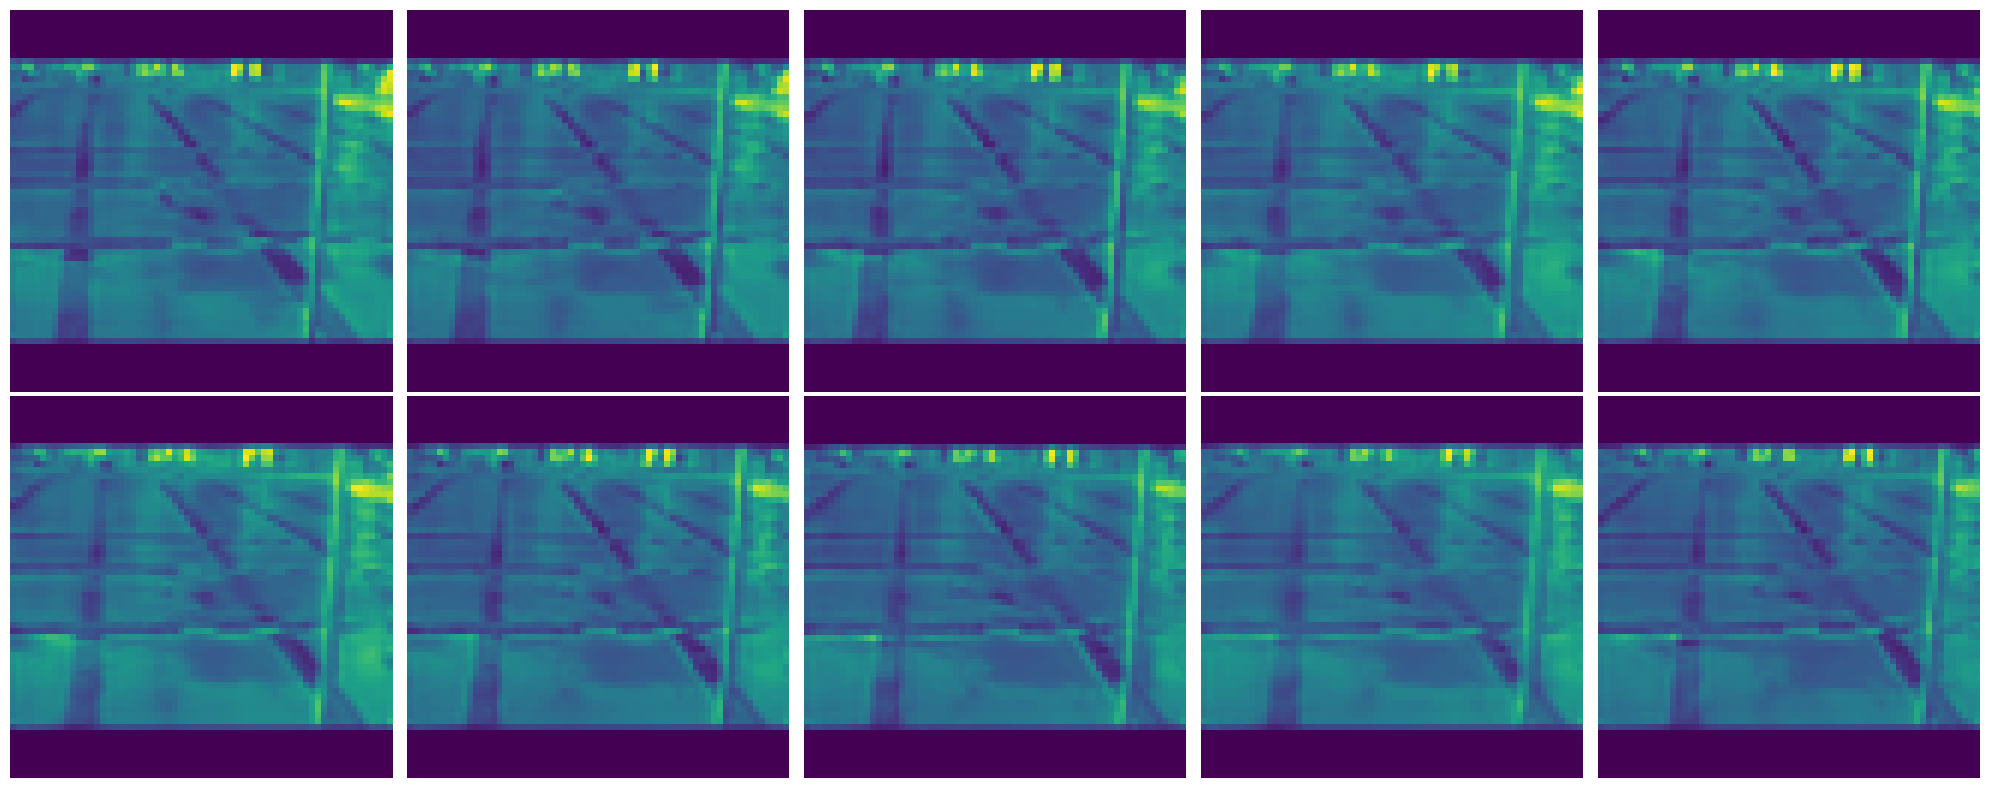

In [46]:
generated_frames=generate_frames(
    model=model,
    data_loader=test_loader,
    device=device
)
generated_frames=np.concatenate(
    generated_frames,
    axis=0
)
_, axes=plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(20, 8)
)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X=generated_frames[i][0])
    ax.axis("off")
plt.tight_layout()
plt.show()

In [47]:
video_frames=[frame.transpose(1, 2, 0) for frame in generated_frames]
video_path=r"Pred_RNN.mp4"
create_video(
    frames=video_frames,
    video_path=video_path
)

Creating Video: 100%|██████████| 4650/4650 [00:00<00:00, 8888.68frame/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp Pred_RNN.pth /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from skimage.metrics import structural_similarity as ssim
def evaluate(
    model: nn.Module,
    criterion: nn.Module,
    test_loader: DataLoader,
    device: torch.device
) -> tuple:
    """
    Evaluates the model on the test set and computes MSE Loss and SSIM.

    Returns:
        Tuple containing average test loss and average SSIM.
    """
    model.eval()
    test_loss = 0.0
    ssim_total = 0.0
    num_frames = 0

    with torch.no_grad():
        for input_frames, target_frame in tqdm(
            iterable=test_loader,
            desc="Testing",
            unit="batch"
        ):
            input_frames = input_frames.to(device)
            target_frame = target_frame.to(device)

            output = model(input_frames)

            loss = criterion(output, target_frame)
            test_loss += loss.item()

            output_np = output.cpu().numpy()
            target_np = target_frame.cpu().numpy()

            batch_size = output_np.shape[0]
            for i in range(batch_size):
                if output_np.shape[1] == 1:
                    pred = output_np[i, 0, :, :]
                    targ = target_np[i, 0, :, :]
                else:
                    pred = np.mean(output_np[i], axis=0)
                    targ = np.mean(target_np[i], axis=0)

                pred = np.clip(pred, 0, 1)
                targ = np.clip(targ, 0, 1)

                ssim_val = ssim(pred, targ, data_range=1.0)
                ssim_total += ssim_val
                num_frames += 1

    average_loss = test_loss / len(test_loader)
    average_ssim = ssim_total / num_frames if num_frames > 0 else 0

    return average_loss, average_ssim


In [54]:
test_loss, test_ssim = evaluate(
    model=model,
    criterion=criterion,
    test_loader=test_loader,
    device=device
)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")


Testing: 100%|██████████| 30/30 [00:15<00:00,  1.90batch/s]

Test Loss (MSE): 0.0013
Test SSIM: 0.9215


In [ ]:
import torch
from src.rnn import PredRNN
model_path = r"Pred_RNN.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
n_channels = 3
n_kernels = 64
n_layers = 2
kernel_size = 3
padding = 1
activation = "relu"
model = PredRNN(
    input_channels=n_channels,
    hidden_channels=n_kernels,
    kernel_size=kernel_size,
    padding=padding,
    n_layers=n_layers,
    activation=activation
).to(device)


model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()

print(f"Model loaded from {model_path} and set to evaluation mode.")

Model loaded from Pred_RNN.pth and set to evaluation mode.


In [57]:
test_loss, test_ssim = evaluate(
    model=model,
    criterion=criterion,
    test_loader=test_loader,
    device=device
)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")


Testing: 100%|██████████| 30/30 [00:15<00:00,  1.91batch/s]

Test Loss (MSE): 0.0013
Test SSIM: 0.9215
